In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [3]:
!kaggle datasets download -d soumikrakshit/anime-faces

 98% 432M/441M [00:06<00:00, 77.1MB/s]
100% 441M/441M [00:06<00:00, 74.1MB/s]


In [4]:
!unzip anime-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/data/552.png       
  inflating: data/data/5520.png      

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from IPython import display
import cv2
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


BATCH_SIZE = 32
NUM_FEATURES = 100
SEED = tf.random.normal(shape=[BATCH_SIZE, NUM_FEATURES])
X = []
for dirname, _, filenames in os.walk('data/data'):
    for filename in filenames:
        input_path = os.path.join(dirname, filename)
        im = cv2.imread(input_path)
        X.append(im)
X = np.array(X) / 255.0

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
X.min()

0.0

In [7]:
from keras.constraints import Constraint
class WeightClipConstraint(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, clip_value):
        self.clip_value = clip_value

    def __call__(self, weights):
        return keras.backend.clip(weights, -self.clip_value, self.clip_value)

    def get_config(self):
        return {'clip_value': self.clip_value}

Using TensorFlow backend.


In [8]:
def wasserstein_loss(y_true, y_pred):
    return keras.backend.mean(y_true * y_pred)


def get_generator(num_features):
    init = keras.initializers.RandomNormal(stddev=0.01)
    
    model = keras.models.Sequential([
                        keras.layers.Dense(4 * 4 * 512, input_shape=[num_features]),
                        keras.layers.Reshape([4, 4, 512]),
                        keras.layers.BatchNormalization(momentum=0.5),
                        keras.layers.ReLU(),
                        keras.layers.Conv2DTranspose(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=init),
                        keras.layers.BatchNormalization(momentum=0.5),
                        keras.layers.ReLU(),
                        keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=init),
                        keras.layers.BatchNormalization(momentum=0.5),
                        keras.layers.ReLU(),
                        keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=init),
                        keras.layers.BatchNormalization(momentum=0.5),
                        keras.layers.ReLU(),
                        keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=init, activation='tanh')
    ])
    
    optimizer = keras.optimizers.RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=optimizer)

    print(model.summary())
    return model


def get_discriminator(input_shape=(64, 64, 3)):
    init = keras.initializers.RandomNormal(stddev=0.01)
    constraint = WeightClipConstraint(0.01)
    model = keras.models.Sequential([
#                             Downsample to 32*32
                            keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=input_shape, kernel_initializer=init, kernel_constraint=constraint),
                            keras.layers.LeakyReLU(0.2),
#                             Downsample to 16*16
                            keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=init, kernel_constraint=constraint),
                            keras.layers.BatchNormalization(momentum=0.5),
                            keras.layers.LeakyReLU(0.2),
#                             keras.layers.Dropout(0.3),
#                             Downsample to 8*8
                            keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=init, kernel_constraint=constraint),
                            keras.layers.BatchNormalization(momentum=0.5),
                            keras.layers.LeakyReLU(0.2),
#                             keras.layers.Dropout(0.3),
                            keras.layers.Conv2D(filters=512, kernel_size=(5, 5), strides=(1, 1), padding='same', kernel_initializer=init, kernel_constraint=constraint),
                            keras.layers.BatchNormalization(momentum=0.5),
                            keras.layers.LeakyReLU(0.2),
#                             keras.layers.Dropout(0.3),
                            keras.layers.Flatten(),
                            keras.layers.Dense(1, activation='linear')
    ])
    optimizer = keras.optimizers.RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=optimizer)
    print(model.summary())
    return model


def get_gan(generator, discriminator):
    discriminator.trainable = False
    model = keras.models.Sequential([generator, discriminator])
    optimizer = keras.optimizers.RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=optimizer) 
    return model

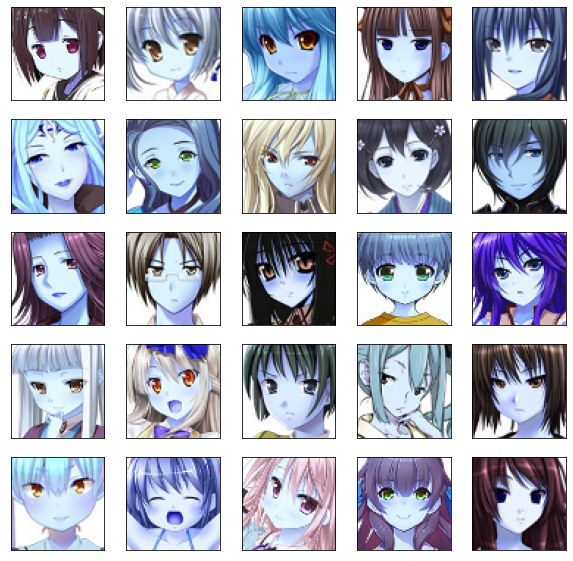

In [9]:
fig, a = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
  for j in range(5):
    a[i][j].imshow(random.choice(X))
    a[i][j].set_xticks([])
    a[i][j].set_yticks([])
plt.show()

In [10]:
generator = get_generator(NUM_FEATURES)
discriminator = get_discriminator((64, 64, 3))
gan = get_gan(generator, discriminator)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 4, 4, 512)         2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 256)         0

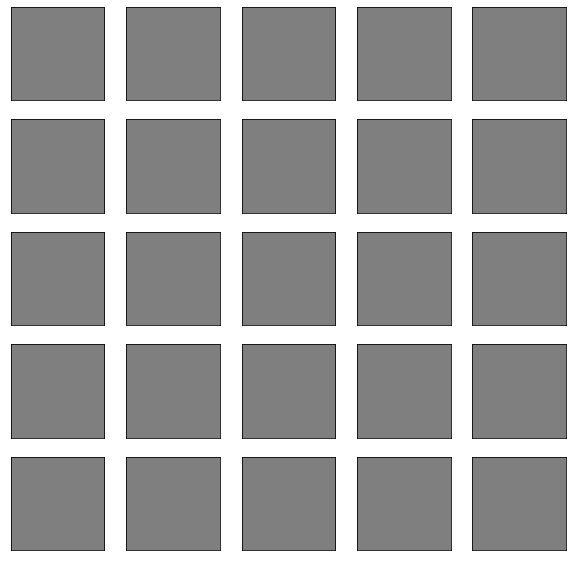

In [11]:
fig, a = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
  for j in range(5):
    noise = tf.random.normal(shape=[1, NUM_FEATURES])
    random_image = (generator(noise)[0] + 1) / 2.0
    a[i][j].imshow(random_image)
    a[i][j].set_xticks([])
    a[i][j].set_yticks([])
plt.show()

In [12]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input, save=True):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  test_input.shape
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(25):
      plt.subplot(5, 5, i+1)
      plt.imshow((predictions[i, :, :, :] + 1.0) / 2.0)
      plt.axis('off')
  if(save):
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [13]:
import random
def train(gan, dataset, batch_size, num_features, seed, n_steps, n_discriminator=5):
    generator, discriminator = gan.layers
    for step in range(n_steps):
        print("Step: " + str(step))
        for _ in range(n_discriminator):
            indices = random.sample(range(0, dataset.shape[0]), batch_size)
            X_batch = dataset[indices]
            noise = tf.random.normal(shape=[batch_size, num_features])
            generated_images = generator(noise)
            X_all = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[-1]] * batch_size + [[1]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_all, y1)
        noise = tf.random.normal(shape=[2 * batch_size, num_features])
        y2 = tf.constant([[1]] * (batch_size * 2))
        discriminator.trainable = False
        gan.train_on_batch(noise, y2)
        if(step%100 == 0):
            display.clear_output(wait=True)
            if(step%1000 == 0):
              generate_and_save_images(generator, step+1, seed)
              gan.save_weights('model_weight')
            else:
              generate_and_save_images(generator, step+1, seed, False)


def train_wgan(gan, dataset, batch_size, num_features, epochs, seed, n_discriminator=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch: " + str(epoch))
        for _ in range((int) (dataset.shape[0]/(batch_size*2))):
            for _ in range(n_discriminator):
                indices = random.sample(range(0, dataset.shape[0]), batch_size)
                X_batch = dataset[indices]
                noise = tf.random.normal(shape=[batch_size, num_features])
                generated_images = generator(noise)
                X_all = tf.concat([generated_images, X_batch], axis=0)
                y1 = tf.constant([[1]] * batch_size + [[-1]] * batch_size)
                discriminator.trainable = True
                discriminator.train_on_batch(X_all, y1)
            noise = tf.random.normal(shape=[2 * batch_size, num_features])
            y2 = tf.constant([[-1]] * (batch_size * 2))
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [14]:
x_train_wgan = X.reshape(-1, 64, 64, 3) * 2. - 1.

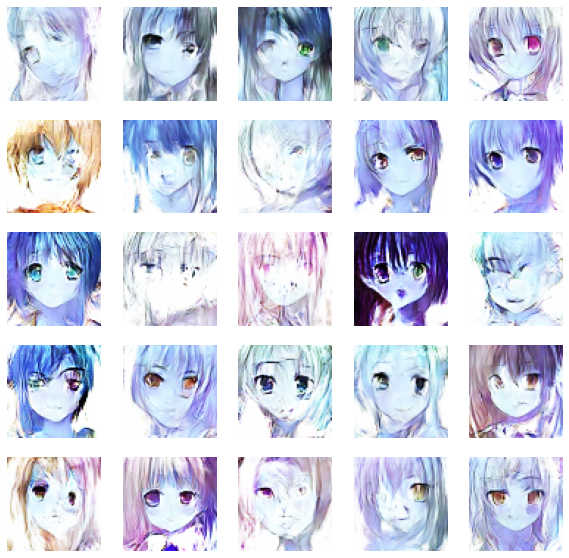

Step: 19901
Step: 19902
Step: 19903
Step: 19904
Step: 19905
Step: 19906
Step: 19907
Step: 19908
Step: 19909
Step: 19910
Step: 19911
Step: 19912
Step: 19913
Step: 19914
Step: 19915
Step: 19916
Step: 19917
Step: 19918
Step: 19919
Step: 19920
Step: 19921
Step: 19922
Step: 19923
Step: 19924
Step: 19925
Step: 19926
Step: 19927
Step: 19928
Step: 19929
Step: 19930
Step: 19931
Step: 19932
Step: 19933
Step: 19934
Step: 19935
Step: 19936
Step: 19937
Step: 19938
Step: 19939
Step: 19940
Step: 19941
Step: 19942
Step: 19943
Step: 19944
Step: 19945
Step: 19946
Step: 19947
Step: 19948
Step: 19949
Step: 19950
Step: 19951
Step: 19952
Step: 19953
Step: 19954
Step: 19955
Step: 19956
Step: 19957
Step: 19958
Step: 19959
Step: 19960
Step: 19961
Step: 19962
Step: 19963
Step: 19964
Step: 19965
Step: 19966
Step: 19967
Step: 19968
Step: 19969
Step: 19970
Step: 19971
Step: 19972
Step: 19973
Step: 19974
Step: 19975
Step: 19976
Step: 19977
Step: 19978
Step: 19979
Step: 19980
Step: 19981
Step: 19982
Step: 19983
Step

In [15]:
train(gan, x_train_wgan, BATCH_SIZE, NUM_FEATURES, SEED, 20000)

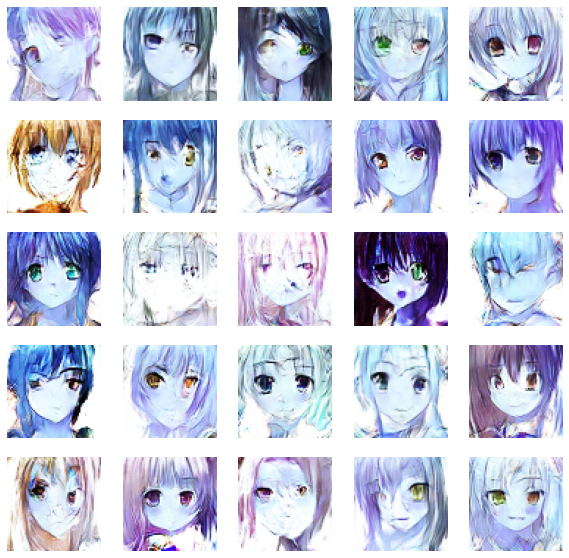

Step: 29901
Step: 29902
Step: 29903
Step: 29904
Step: 29905
Step: 29906
Step: 29907
Step: 29908
Step: 29909
Step: 29910
Step: 29911
Step: 29912
Step: 29913
Step: 29914
Step: 29915
Step: 29916
Step: 29917
Step: 29918
Step: 29919
Step: 29920
Step: 29921
Step: 29922
Step: 29923
Step: 29924
Step: 29925
Step: 29926
Step: 29927
Step: 29928
Step: 29929
Step: 29930
Step: 29931
Step: 29932
Step: 29933
Step: 29934
Step: 29935
Step: 29936
Step: 29937
Step: 29938
Step: 29939
Step: 29940
Step: 29941
Step: 29942
Step: 29943
Step: 29944
Step: 29945
Step: 29946
Step: 29947
Step: 29948
Step: 29949
Step: 29950
Step: 29951
Step: 29952
Step: 29953
Step: 29954
Step: 29955
Step: 29956
Step: 29957
Step: 29958
Step: 29959
Step: 29960
Step: 29961
Step: 29962
Step: 29963
Step: 29964
Step: 29965
Step: 29966
Step: 29967
Step: 29968
Step: 29969
Step: 29970
Step: 29971
Step: 29972
Step: 29973
Step: 29974
Step: 29975
Step: 29976
Step: 29977
Step: 29978
Step: 29979
Step: 29980
Step: 29981
Step: 29982
Step: 29983
Step

In [16]:
generator, discriminator = gan.layers
for step in range(20000, 30000 ):
    print("Step: " + str(step))
    for _ in range(5):
        indices = random.sample(range(0, x_train_wgan.shape[0]), BATCH_SIZE)
        X_batch = x_train_wgan[indices]
        noise = tf.random.normal(shape=[BATCH_SIZE, NUM_FEATURES])
        generated_images = generator(noise)
        X_all = tf.concat([generated_images, X_batch], axis=0)
        y1 = tf.constant([[-1]] * BATCH_SIZE + [[1]] * BATCH_SIZE)
        discriminator.trainable = True
        discriminator.train_on_batch(X_all, y1)
    noise = tf.random.normal(shape=[2 * BATCH_SIZE, NUM_FEATURES])
    y2 = tf.constant([[1]] * (BATCH_SIZE * 2))
    discriminator.trainable = False
    gan.train_on_batch(noise, y2)
    if(step%100 == 0):
        display.clear_output(wait=True)
        if(step%1000 == 0):
          generate_and_save_images(generator, step+1, SEED)
          gan.save_weights('model_weight')
        else:
          generate_and_save_images(generator, step+1, SEED, False)
